<br />


<br /><br />
<b>Program Description</b><br />
- This program compares Phoenix violent crime rate (%) to median annual temperature across 2004-2019 to investigate whether increased temperatures correlate to increases in violent crime.  

<b>Thought process that led to this hypothesis:</b><br />
- What are the less obvious social effects of climate change?<br />
<em>- Too broad.</em> <br /><br />
- Do rising temperatures increase violence directly or through drought and food shortage (or other means, all of these)? <br />
<em>- Not remotely narrow enough.</em> <br /><br />
- Is there a measurable connection between rising temps and human hostility?<br />
<em>- Still too broad - am I measuring this at the scale of planet Earth? </em><br /><br />

<b>Questions this exploratory program aims to investigate:</b><br />
- Is violent crime rate correlated with temperature among Phoenix over a 15-year period?<br />
- Has that correlation changed over time (as average temperature has increased)?
<br /><br />

In [1]:
import pandas as pd
from zipfile import ZipFile
from io import BytesIO
import config 
pd.set_option('display.max_columns', None)

<br />

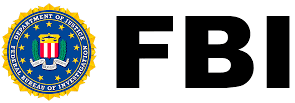
<br /><br />
<center>All crime data is from the FBI <a href='https://crime-data-explorer.fr.cloud.gov/pages/downloads'>Crime Data Explorer</a></center>

In [2]:
# I created a file that includes the subset of offense types to consider violent crimes
df_offense_types = pd.read_csv(config.CRIME_TYPES_CSV )
violent_offense_type_ids = df_offense_types.offense_type_id

<br />Here are the offense types initially considered violent crimes for this study.
- Justifiable Homicide
- Destruction/Damage/Vandalism of Property
- Arson
- Aggravated Assault
- Kidnapping/Abduction
- Murder and Nonnegligent Manslaughter
- Negligent Manslaughter
- Weapon Law Violations
- Intimidation
- Simple Assault
- Disorderly Conduct
- Animal Cruelty

The FBI data is spread across zip files with dozens of CSV files within each zip.  The CSV file content represents a relational database so numeric keys point across to other files to support joining.  In other words, it is a heap of files and no single file has the entire story.  
<br /><br />

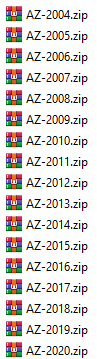
&nbsp;&nbsp;
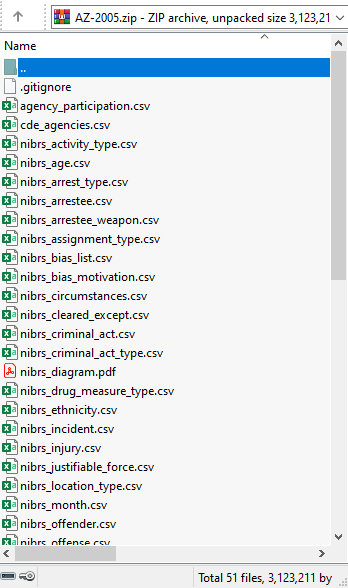

In [3]:
# we have crime archives from 2004 to 2020, omitting 2020 due to an observed dramatic increase in violence perhaps due to
# the pandemic

# the zip and csv files require wrangling since the file format changed in 2017 and later: 
# - different folder structure
# - different column layout
# - different naming convention (upper versus lower case)

all_years={}
total_offenses={}

for year_step in range(2004,2020):
    print("Loading: "+str(year_step))
    offense_file = 'nibrs_offense.csv'
    incident_file = 'nibrs_incident.csv'
    #beginning in 2018 they tucked everything into a subfolder 'AZ'
    if year_step >= 2017:
        offense_file = 'AZ/NIBRS_OFFENSE.csv'
        incident_file = 'AZ/NIBRS_incident.csv'
    year_data = ZipFile(config.DATA_FOLDER+"/AZ-"+str(year_step)+".zip")
    
    # load offenses
    with year_data.open(offense_file) as off_file:
        df_year_offense_data=pd.read_csv(off_file)
    # some are all capital letters
    df_year_offense_data.columns= df_year_offense_data.columns.str.lower()
    
    with year_data.open(incident_file) as inc_file:
        df_year_incident_data=pd.read_csv(inc_file)
    df_year_incident_data.columns= df_year_incident_data.columns.str.lower()
    
    total_offenses[year_step]=len(df_year_incident_data)
    
    # isolate all of the violent offenses, deal with file format inconsistency
    # also set a consistent a type column so we are not dealing with variation later
    df_year_offense_data.query("offense_type_id in @violent_offense_type_ids", inplace=True)
    df_year_offense_data=pd.merge(df_year_offense_data, df_year_incident_data, on='incident_id')
    
    all_years[year_step] = df_year_offense_data


Loading: 2004
Loading: 2005
Loading: 2006
Loading: 2007
Loading: 2008
Loading: 2009
Loading: 2010
Loading: 2011
Loading: 2012
Loading: 2013
Loading: 2014
Loading: 2015
Loading: 2016
Loading: 2017
Loading: 2018
Loading: 2019


In [4]:
# check a sample of data
all_years[2004].head()

,offense_id,incident_id,offense_type_id,attempt_complete_flag,location_id,num_premises_entered,method_entry_code,ff_line_number_x,agency_id,nibrs_month_id,incident_number,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,ddocname,orig_format,ff_line_number_y,did
0,29165117,23610494,5,C,20,NaN,NaN,NaN,895,3417562,041110010,NaN,NaN,2004-07-01 00:00:00,NaN,NaN,6,NaN,0,C,2004_07_AZ0111300_041110010_INC_NIBRS,NaN,NaN,NaN
1,28542654,25162242,5,C,20,NaN,NaN,NaN,895,3417562,040714006,NaN,NaN,2004-07-14 00:00:00,NaN,12.0,6,NaN,0,C,2004_07_AZ0111300_040714006_INC_NIBRS,NaN,NaN,NaN
2,28551081,25162249,5,C,20,NaN,NaN,NaN,895,3417562,040715005,NaN,NaN,2004-07-15 00:00:00,NaN,2.0,6,NaN,0,C,2004_07_AZ0111300_040715005_INC_NIBRS,NaN,NaN,NaN
3,28538872,25162251,5,C,20,NaN,NaN,NaN,895,3417562,040715010,NaN,NaN,2004-07-14 00:00:00,NaN,18.0,6,NaN,0,C,2004_07_AZ0111300_040715010_INC_NIBRS,NaN,NaN,NaN
4,28547615,25162253,5,C,20,NaN,NaN,NaN,895,3417562,040716001,NaN,NaN,2004-07-16 00:00:00,NaN,0.0,6,NaN,0,C,2004_07_AZ0111300_040716001_INC_NIBRS,NaN,NaN,NaN


In [5]:
#let's take a look at the crime types we found across years
for x in all_years:
    print(len(all_years[x]))
    print(sorted(all_years[x].offense_type_id.unique()))

1516
[5, 20, 27, 29, 39, 44, 51]
2585
[5, 20, 27, 29, 32, 39, 44, 51]
2589
[5, 20, 27, 29, 32, 39, 44, 51]
3054
[5, 20, 27, 29, 32, 39, 44, 51]
3295
[5, 20, 27, 29, 32, 39, 44, 51]
6589
[5, 20, 27, 29, 32, 39, 44, 51]
6061
[5, 20, 27, 29, 32, 39, 44, 51]
5687
[5, 20, 27, 29, 32, 39, 44, 51]
5620
[5, 20, 27, 29, 32, 39, 44, 51]
8758
[5, 20, 27, 29, 32, 38, 39, 44, 51]
8451
[5, 20, 27, 29, 32, 38, 39, 44, 51]
7869
[1, 5, 20, 27, 29, 32, 38, 39, 44, 51]
6957
[1, 5, 20, 27, 29, 32, 38, 39, 44, 51]
7896
[5, 20, 27, 29, 32, 38, 39, 44, 51]
7507
[5, 20, 27, 29, 32, 38, 39, 44, 51, 62]
8856
[5, 20, 27, 29, 32, 38, 39, 44, 51, 62]


In [6]:
# we have a problem - not all crime type codes were used across all years
# I suppose it is nice to see justifiable homicide is not always in the mix
# other codes appear to be newly utilized so let's trim this down to common codes
codes_to_drop=[1, 38, 62] # dropping justifiable homicide, animal cruelty, negligent manslaughter
for year_step in range(2004,2020):
    all_years[year_step].query("offense_type_id not in @codes_to_drop", inplace=True)

In [7]:
# checking remaining crime types
for x in all_years:
    print(len(all_years[x]))
    print(sorted(all_years[x].offense_type_id.unique()))

1516
[5, 20, 27, 29, 39, 44, 51]
2585
[5, 20, 27, 29, 32, 39, 44, 51]
2589
[5, 20, 27, 29, 32, 39, 44, 51]
3054
[5, 20, 27, 29, 32, 39, 44, 51]
3295
[5, 20, 27, 29, 32, 39, 44, 51]
6589
[5, 20, 27, 29, 32, 39, 44, 51]
6061
[5, 20, 27, 29, 32, 39, 44, 51]
5687
[5, 20, 27, 29, 32, 39, 44, 51]
5620
[5, 20, 27, 29, 32, 39, 44, 51]
8756
[5, 20, 27, 29, 32, 39, 44, 51]
8449
[5, 20, 27, 29, 32, 39, 44, 51]
7865
[5, 20, 27, 29, 32, 39, 44, 51]
6953
[5, 20, 27, 29, 32, 39, 44, 51]
7894
[5, 20, 27, 29, 32, 39, 44, 51]
7498
[5, 20, 27, 29, 32, 39, 44, 51]
8809
[5, 20, 27, 29, 32, 39, 44, 51]


In [8]:
# 2004 is still missing Murder and Nonnegligent Manslaughter and that is too important for us to ignore
# dropping it leaves us with a type-consistent 15yr spread
del all_years[2004]
del total_offenses[2004]

In [9]:
# begin assembling macro-scale data
dict = {}
for year_step in range(2005,2020):
    dict[year_step]={'year':year_step,'violent_crime':len(all_years[year_step])}
annual_violent_crime = pd.DataFrame(dict)
annual_violent_crime = annual_violent_crime.T
annual_violent_crime

,year,violent_crime
2005,2005,2585
2006,2006,2589
2007,2007,3054
2008,2008,3295
2009,2009,6589
2010,2010,6061
2011,2011,5687
2012,2012,5620
2013,2013,8756
2014,2014,8449


<AxesSubplot:title={'center':'Phoenix Violent Crime Occurences\nYears: 2005-2019'}>

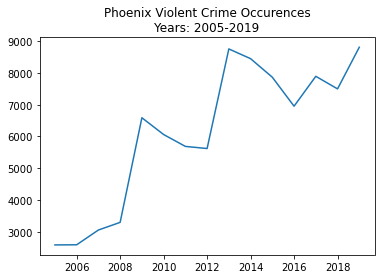

In [10]:
# how does the crime trend look?
annual_violent_crime.violent_crime.plot(title="Phoenix Violent Crime Occurences\nYears: 2005-2019")

In [11]:
# crime appears to be going up from 2005 through 2019
# we should consider relative volume, though (total violent crime rate)
for year_step in range(2005,2020):
    crime_pct = int(annual_violent_crime[annual_violent_crime.year==year_step].violent_crime / total_offenses[year_step] *100)
    annual_violent_crime.loc[year_step,'crime_pct']=crime_pct
    annual_violent_crime.loc[year_step,'total_offenses']=total_offenses[year_step]
annual_violent_crime

,year,violent_crime,crime_pct,total_offenses
2005,2005,2585,45.0,5621.0
2006,2006,2589,45.0,5737.0
2007,2007,3054,46.0,6591.0
2008,2008,3295,47.0,6971.0
2009,2009,6589,46.0,14241.0
2010,2010,6061,43.0,13836.0
2011,2011,5687,44.0,12805.0
2012,2012,5620,44.0,12623.0
2013,2013,8756,44.0,19899.0
2014,2014,8449,43.0,19467.0


<AxesSubplot:title={'center':'Phoenix Annual Violent Crime Rate (%)\nYears: 2005-2019'}>

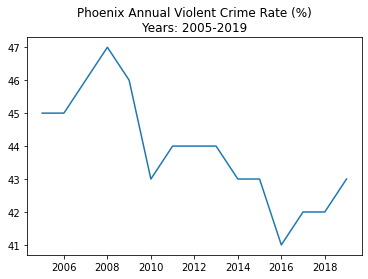

In [12]:
annual_violent_crime.crime_pct.plot(title="Phoenix Annual Violent Crime Rate (%)\nYears: 2005-2019")

<br /><br /><b>Violent crime is actually going down.
What about temperatures during this timespan?</b>

<br />

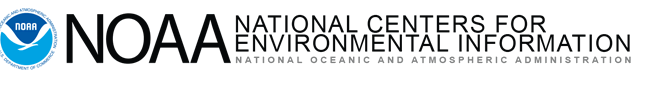
<br /><br />
<center>Loading data from <a href='https://www.ncdc.noaa.gov/'>NOAA</a>.  All temperatures are in Celsius.</center>

In [13]:
# I learned this regarding the columnar data: 
# dry-bulb temperature is the temperature of air measured by a thermometer freely exposed to the air, 
# but shielded from radiation and moisture. DBT is the temperature that is usually thought of as air temperature, 
# and it is the true thermodynamic temperature.  
#
# Interesting fact but we want wet bulb since human beings are not shielded in such ways.

def load_weather_data(file):
    '''
        This method parses and cleans up NOA weather data files.
        It returns a dataframe.  
    '''
    idf = pd.DataFrame()
    idf = pd.read_csv(file, low_memory=False)
    
    # address case inconsistency across files
    idf.columns= idf.columns.str.lower()
    
    # add a column that will indicate the year of the reading based on the reading long date
    idf['reading_year'] = pd.DatetimeIndex(idf.date).year

    # get rid of nan values
    idf = idf.dropna(subset=['hourlywetbulbtemperature'])

    # remove where there is an asterisk instead of a value
    idf = idf.loc[idf['hourlywetbulbtemperature']!='*']

    # cast weather values down to integers since types are mixed
    idf.hourlywetbulbtemperature=pd.to_numeric(idf.hourlywetbulbtemperature, downcast='integer')
    
    return idf


# load Phoenix weather data for 2004-2013
weather_df_0413 = load_weather_data(config.DATA_FOLDER+"/Phoenix Airport Data 2-24-2004 to 2-22-2013.csv")

# drop 2004 since our crime data starts at 2005
weather_df_0413 = weather_df_0413.loc[weather_df_0413['reading_year']!=2004]


# load Phoenix weather data for 2013-2022
weather_df_1320 = load_weather_data(config.DATA_FOLDER+"/Phoenix Airport Data 2-22-2013 to 2-22-2022.csv")

# drop 2022, 2021, 2020 since our crime data caps out at 2019
weather_df_1320 = weather_df_1320.loc[((weather_df_1320['reading_year']!=2022) & \
                                       (weather_df_1320['reading_year']!=2021) & \
                                       (weather_df_1320['reading_year']!=2020))]

# these files have 125 columns
weather_df_1320.shape

(71362, 125)

In [14]:
# let's check if the file content is complete
weather_df_1320.reading_year.value_counts()

2018    10476
2016    10456
2015    10401
2019    10390
2014    10374
2017    10372
2013     8893
Name: reading_year, dtype: int64

In [15]:
# we can see 2013 is partitioned across the yearspan dataframes
# let's concatenate the two to complete our yearspan and combine the 2013 data
frames = [weather_df_0413,weather_df_1320]
all_weather = pd.concat(frames)
all_weather.reading_year.value_counts()

2018    10476
2011    10457
2016    10456
2008    10417
2013    10409
2012    10402
2015    10401
2007    10399
2019    10390
2014    10374
2017    10372
2006    10359
2010    10358
2009    10341
2005    10318
Name: reading_year, dtype: int64

In [16]:
# build an annual view of temperature readings
dict = {}
for year_step in range(2005,2020):
    # using median because there are clear outliers
    median_temp = all_weather[all_weather.reading_year==year_step]['hourlywetbulbtemperature'].median()
    dict[year_step]={'year':year_step,'median_temp':median_temp}
annual_temperatures = pd.DataFrame(dict)
annual_temperatures

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
year,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
median_temp,56.0,54.0,56.0,54.0,55.0,54.0,54.0,55.0,55.0,56.0,57.0,56.0,56.0,56.0,56.0


In [17]:
# transpose to support plotting
annual_temperatures=annual_temperatures.T

<AxesSubplot:title={'center':'Phoenix Median Annual Temperature\nYears: 2005-2019'}>

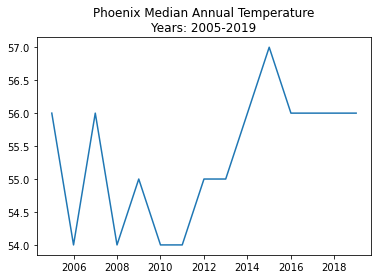

In [18]:
annual_temperatures.median_temp.plot(title="Phoenix Median Annual Temperature\nYears: 2005-2019")

<AxesSubplot:title={'center':'Median Temp (blue) vs Violent Crime Rate (orange)\nYears: 2005-2019'}>

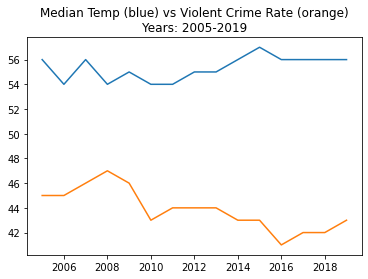

In [19]:
# time to compare annual violent crime rate to annual median temp
ax = annual_temperatures.median_temp.plot()
annual_violent_crime.crime_pct.plot(ax=ax,title="Median Temp (blue) vs Violent Crime Rate (orange)\nYears: 2005-2019")

<br /><b>We have found an inverse effect for this time period in Phoenix: temp is trending up and violent crime is trending down</b>
- Perhaps if we went to the regional level this would change like it did in the Helman et al. study below
- Over a greater time period effect confirmation might emerge
- Seasonal variation and associated effects may be worth investigating
- Crime suppression may be a result of policies or other forms of mitigation
- The result suggests we should explroe weather colder weather and increased violence are correlated
- Economic and other social factors are worthy of consideration

<br />

<b>Literature Review</b>

<i>Example study where panning out to a region revealed confirmation of the effect after an inverse effect at city-scale:</i>
<br />
Helman, David, Benjamin F. Zaitchik, and Chris Funk. “Climate Has Contrasting Direct and Indirect Effects on Armed Conflicts.” Environmental Research Letters 15, no. 10 (2020): 104017-. https://doi.org/10.1088/1748-9326/aba97d.

<i>Discussion of the 'Heat Hypothesis' which asserts a connection between heat and violence:</i>
<br />
Anderson, C. A. (2001). Heat and Violence. Current Directions in Psychological Science, 10(1):33-8. https://www2.psych.ubc.ca/~schaller/308Readings/Anderson2001.pdf 

<i>The CLASH model further indicates a link between heat and violence:</i>
<br />
Van Lange, Paul A. M, Maria I Rinderu, and Brad J Bushman. “Aggression and Violence Around the World: A Model of CLimate, Aggression, and Self-Control in Humans (CLASH).” The Behavioral and brain sciences 40 (2017): e75–e75.
<br />

<i>This article suggests higher temperatures lead to increases in domestic violane against women</i>
<br />
Sanz-Barbero, Belén, Cristina Linares, Carmen Vives-Cases, José Luis González, Juan José López-Ossorio, and Julio Díaz. “Heat Wave and the Risk of Intimate Partner Violence.” Science of The Total Environment 644 (December 2018): 413–19. https://doi.org/10.1016/j.scitotenv.2018.06.368.

<i>This article speaks against the CLASH model cited above by highlighting purported bias</i>
<br />
Van Voorhees, Elizabeth E, Sarah M Wilson, Patrick S Calhoun, Eric B Elbogen, Jean C Beckham, and Nathan A Kimbrel. “Sociocultural Discourse in Science: Flawed Assumptions and Bias in the CLASH Model.” The Behavioral and brain sciences 40 (2017): 38–40.

<br /><br />